# Actividad laboratorio: Estimación de parámetros de un activo financiero

## Objetivos

El objetivo de esta actividad es programar y así tener soltura a la hora de manejar datos financieros.

## Pautas de elaboración

En uno de los recursos audiovisuales se ha explicado como ir a una base de datos donde aparecen las cotizaciones de las grandes empresas en el IBEX-35. En primer lugar, se recomienda considerar un activo, descargarse los datos y ajustar los parámetros del modelo log-normal utilizando dos de los tres métodos de estimación que se explican en el Tema 6.

## Parte 1: Definición de las funciones que vamos a utilizar y carga de librerías

En python hay multitud de librerías que podemos utilizar, en este caso utilizaremos librerías standar para el analísis de datos y acceder a la base de datos de Yahoo Finance.
Además, vamos a definir una serie de funciones para proceder a ajustar un modelo log-normal.

El modelo Log-Normal se puede describir matemáticamente como:
$$ 
    \begin{cases}
    dS(t) = \mu S(t) + \sigma S(t)dW(t)\ \ donde \  \mu \in \mathbb{R} \ y \ \sigma >0, \\
    S(0) = s_0
    \end{cases} 
$$
Aplicando el Lema de Ito y resolviendo la EDE, obtenemos que $S(t) = s_0 \cdot e^{(\mu - \frac{1}{2}\sigma ^2)t + \sigma W(t) }$

### Librerías

In [50]:
#pip install yfinance   -> Con esta librería podemos conectarnos a los datos de Yahoo Finance.
#pip install pandas     -> Librería por excelencia para el manejo de DataFrames con python.
#pip install numpy      -> Librería por excelencia para el manejo de arrays de datos con python.
#pip install mplfinance -> Librería para hacer candle plots.
#pip install math       -> Librería por excelencia para utilizar funciones matemáticas.

import yfinance as yf  
import pandas as pd 
import numpy as np
import mplfinance as mpf
from math import exp

### Funciones

####  Media

Aplicando el operador esperanza se obtiene la siguiente expresión: $$ \mathbb{E}[S(t)] = s_0 \cdot e^{\mu t}, $$ Esto lo podemos programar de la siguiente manera:

In [47]:
def media(datos,t = None):
    """
    La siguiente función nos devuelve el media del modelo Log-Normal en el instate t:
    Input:
        - datos(List[Number])   : Datos a analizar.
        - t (Number)      : Vector de tiempos o el instante t. (Valor opcional, si no se rellena, devuelve en cada instante de t)
    Output:
        - eS(List[Number])  : Vector de medias de la solución en todos los instantes o media de la solución en el instante t.
    """
    from math import exp
    mu = 1/len(datos)*sum(datos)
    s0 = datos[0]
    eS = []
    if t:
        eS.append(s0*exp(mu*t))
    else:
        for t in range(len(datos)):
            eS.append(s0*exp(mu*(t)))
    return(eS)

Aplicando el operador esperanza se obtiene la siguiente expresión: $$ \mathbb{V}[S(t)] = \mathbb{E}[S(t)^2] - \mathbb{E}[S(t)]^2 = s_0^2 \cdot e^{2 \mu t} \cdot (e^{\sigma^2 t} - 1), $$ Esto lo podemos programar de la siguiente manera:

In [48]:
def desvTipica(datos,t = None):
    """
    La siguiente función nos devuelve la desviación típica del modelo Log-Normal en el instate t:
    Input:
        - datos(List[Number])   : Datos a analizar.
        - t (Number)      : Vector de tiempos o el instante t. (Valor opcional, si no se rellena, devuelve en cada instante de t)
    Output:
        - eS(List[Number])  : Vector desviación típica la solución en todos los instantes o desviación típica de la solución en el instante t.
    """
    from math import exp, sqrt
    import numpy as np 
    mu = np.mean(datos)
    sigma2 = np.std(datos)**2
    s0 = datos[0]
    eS = []
    if t:
        eS.append(sqrt((s0**2)*exp(2*mu*t)*(exp(sigma2*t)-1)))
    else:
        for t in range(len(datos)):
            eS.append(sqrt((s0**2)*exp(2*mu*t)*(exp(sigma2*t)-1)))
    return(eS)

## Parte 2: Análisis exploratorio de los datos

En esta segunda parte, vamos a analizar de forma libiana los datos y en caso de necesitar alguna transformación para poder aplicar nuestro modelo procederemos con ello.

In [52]:
simbolo = "BBVA.MC"
bbva = yf.Ticker(simbolo)
bbva.info["longBusinessSummary"] + " " + bbva.info["website"]

df = bbva.history(period="max")
df.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-10-21 00:00:00+02:00,5.010,5.032,4.903,4.9995,14963528,0.0,0
2022-10-24 00:00:00+02:00,5.060,5.207,5.027,5.1890,19201990,0.0,0
2022-10-25 00:00:00+02:00,5.204,5.265,5.134,5.2300,17192549,0.0,0
2022-10-26 00:00:00+02:00,5.269,5.290,5.183,5.2210,12919405,0.0,0
2022-10-27 00:00:00+02:00,5.206,5.258,5.127,5.2580,13733183,0.0,0
2022-10-28 00:00:00+02:00,5.197,5.248,5.021,5.2460,20870488,0.0,0
2022-10-31 00:00:00+01:00,5.240,5.272,5.172,5.2090,15559086,0.0,0
2022-11-01 00:00:00+01:00,5.249,5.299,5.229,5.2550,14233887,0.0,0
2022-11-02 00:00:00+01:00,5.298,5.333,5.261,5.2860,12864826,0.0,0


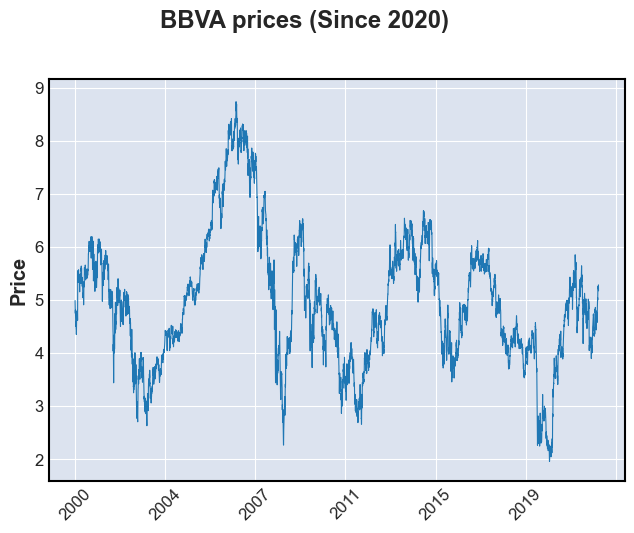

None

In [94]:
display(mpf.plot(df,type='line', title = "BBVA prices (Since 2020)", datetime_format = "%Y" ))

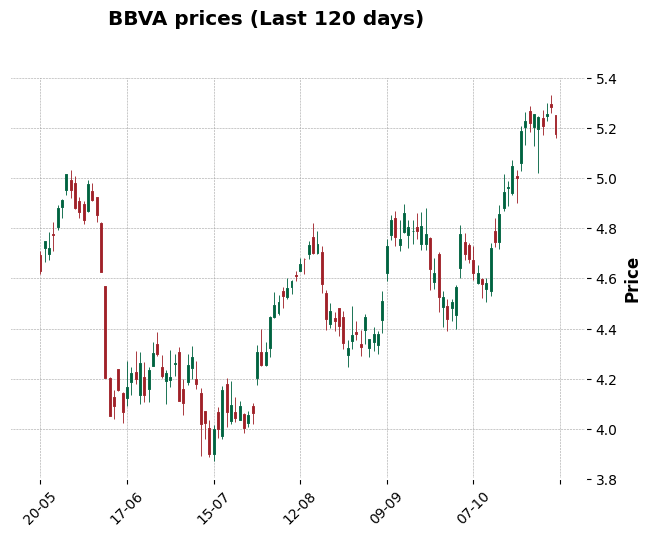

In [93]:
display(mpf.plot(df.iloc[len(df)-120:] ,type='candle', title = "BBVA prices (Last 120 days)", datetime_format = "%d-%m" , style = "charles"))